# Homework 3 - Cedomir Ljubic
## Gradient Descent and Stochastic Gradient Descent

Import first all these librairies   

In [321]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns # for nicer plots
import sys

In this lab, we aim to apply GD and SGD to some particular functions

# II. Application on the Rosenbrock function

In this part, we consider the function
$$
f_3 : w \mapsto (w_1-1)^2 + 100(w_1^2-w_2)^2 \, ,
$$
called the Rosenbrock function.

## Q10. Plot the contour lines of this function.

In [322]:
def rosenbrock(w):
    return (w[0]-1)**2 + 100*(w[0]**2 - w[1])**2

Text(0, 0.5, 'w2')

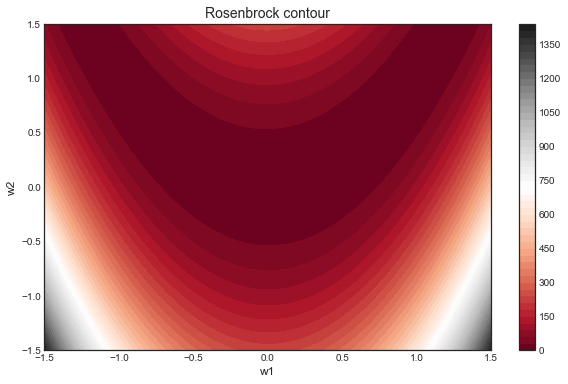

In [323]:
w1 = np.linspace(-1.5, 1.5, 100)
w2 = np.linspace(-1.5, 1.5, 100)
W1, W2 = np.meshgrid(w1, w2)

fig, ax = plt.subplots( figsize = [10, 6])

cs = ax.contourf(W1, W2, rosenbrock((W1, W2)), 50, cmap='RdGy')

fig.colorbar(cs)

ax.set_title('Rosenbrock contour', fontsize=14)
ax.set_xlabel('w1', fontsize=12)
ax.set_ylabel('w2', fontsize=12)

## Q11. Does $f_3$ admit a unique minimizer? If so find it.

If $f_3$ admits one (or more) minimizers, then the gradient of $f_3$ in those points has to be null. Therefore let's see in which points the gradient is null and solve this system of equations:  
$$w_1^2 - w_2 = 0 $$ 
$$200w_1(w_1^2 - w_2) + w_1 - 1 = 0 $$

The unique critical point is in $w_1 = 1$ and $w_2 = 1$ so that is the only value possible for a minimizer.

We have that $ f_3 \geqslant 0 $ and $f_3(1,1) = 0$, therefore $w = (1,1)$ is a minimizer and it is unique.


## Q12. Apply GD to $f_3$ for different choice of learning rates and starting from $w_0 = (-1,1)$. Comment your results.

We will apply gradient descent until convergence:

$$w = w -  \alpha \frac{\partial f_3(w)}{\partial w}$$

In [324]:
def grad_rosen(w):
    grad = np.array([400*w[0]*(w[0]**2 - w[1]) + 2*(w[0] - 1), -200*(w[0]**2 - w[1])])
    return grad

In [325]:
def grad_rosen_descent(w, alpha):
    W = []
    n = 0
    
    # We put the second two conditions in order to stop the algorithm when it starts diverging
    while (rosenbrock(w) > 1e-3) & (w[0] < 1e+50) & (w[1] < 1e+50): 
        
        grad = grad_rosen(w)
        w = w - alpha*grad
        n += 1
        W.append(w)
        
    return W, w, n

Let's try different learning rates $\alpha = [0.1, 0.01, 0.001, 0.0001]$

In [326]:
alphas = [0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    
    W, w, n = grad_rosen_descent(np.array([-1.0, 1.0]), alpha)
    print(f"For alpha = {alpha} the algorithm came to the result {w} after {n} iterations")

For alpha = 0.1 the algorithm came to the result [1.79894913e+53 5.44923985e+35] after 5 iterations
For alpha = 0.01 the algorithm came to the result [-2.17918170e+113  2.87421309e+075] after 8 iterations
For alpha = 0.001 the algorithm came to the result [0.96841599 0.93770073] after 6502 iterations


C:\Users\ivana\Python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


For alpha = 0.0001 the algorithm came to the result [0.9684035  0.93767649] after 65029 iterations


#### We notice that if alpha is too large (such as alpha >= 0.01) gradient descent diverges very fast. 
#### However if alpha is too small, then gradient descent is slow (we see 65k iterations with alpha = 0.0001)

#### The next function is not asked in the homework, but it allows us to plot the evolution of w onto our  contour function.

In [329]:
def contour_with_GD(w0, alpha):  

    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1.5, 1.5, 100)

    
    fig, ax = plt.subplots(figsize = [10, 6])

    cs = ax.contourf(W1, W2, rosenbrock((W1, W2)), 50, cmap='RdGy')
    fig.colorbar(cs)
    
    
    W, w, n = grad_rosen_descent(w0, 0.001)
    w_0 = [W[i][0] for i in range(n)]
    w_1 = [W[i][1] for i in range(n)]
    ax.plot(w_0, w_1, c='black', linestyle=':', label='Gradient descent', marker='1')
    

    ax.set_title('Rosenbrock contour and gradient descent', fontsize=14)
    ax.set_xlabel('w1', fontsize=12)
    ax.set_ylabel('w2', fontsize=12)

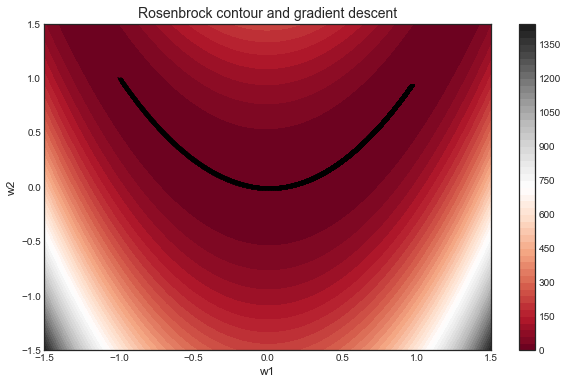

In [330]:
contour_with_GD(np.array([-1.0, 1.0]), 0.001)

# III. Stochastic Gradient Descent for regression

Here we consider the regression problem:
$$
Y = w_0 + w_1 X + \epsilon \, , \, \epsilon \sim \mathrm{N}(0,1) \, .
$$
Therefore, we have to minimize a function $E$ of the form
$$
E(w) = \sum_{i=1}^N E_i(w) \, ,
$$
where $N$ is the number of datapoints and $E_i$ is a function of the $i$-th datapoint.

## Q13. Generate some synthetic data. Plot the training data and the regression line.

We decide to generate synthetic data using the function $ Y = 2 + 5X + \epsilon$, where $\epsilon \sim \mathrm{N}(0,1)$ and $X \sim \mathrm{U}(0,3)$

In [331]:
def create_data(n_train):
    """
    This function creates synthetic data with wo = 2 and w1 = 5
    """
    np.random.seed(10)
    
    # Function parameters w0 and w1
    w = np.array([2, 5])
    X_train = np.zeros((n_train, 2))
    X_train[:, 0] = np.ones(n_train)  # The first column of X_train is the intercept
    X_train[:, 1] = np.sort(np.random.uniform(low = 0.0, high = 3.0, size = n_train))
    
    # additive gaussian noise
    noise_train = np.random.randn(n_train)
    y_train = X_train @ w + noise_train
    
    return X_train, y_train

In [332]:
def plot_regression(n_train):
    """
    This function plots the synthetic data, the underlying function and the regression line
    """   
    # We give the plot a title and axes
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_title("Synthetic data and regression line", fontsize = 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    # We generate the data thanks to our previous function
    X_train, y_train = create_data(n_train)
    ax.scatter(X_train[:, 1], y_train, color = 'b', label = "training data")
    
    # We plot the underlying function used to generate the data
    x = np.linspace(0, 3, 100)
    y_underlying = 2 + 5*x
    ax.plot(x, y_underlying, color = 'g', label = "Function used to generate the data")
    
    # We plot the regression line
    w_star = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
    y_hat = X_train @ w_star
    ax.plot(X_train[:, 1], y_hat, linestyle = ':', color = 'r',  label = "Regression function")
    
    
    ax.legend(loc = 'upper left')
    plt.show()
    print(f"The regression parameters are {w_star}")

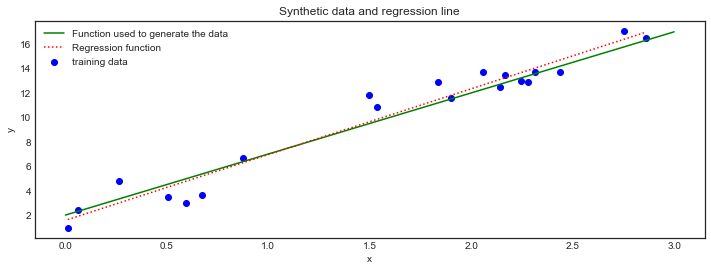

The regression parameters are [1.57080287 5.38349804]


In [333]:
plot_regression(20)

We see the regression line is rather close to the real values $[2, 5]$ even after only 20 training examples

## Q.14 Use GD to estimate the regression line

As a reminder our true parameters are $w_0 = 2$ and $w_1 = 5$. We take as model for y: $f_{w}(x^{(i)}) = w_0 + w_1x^{(i)}$ where we try to approximate $w_0$ and $w_1$.

We define $E_i(w)$ as  $$E_i(w) =  \frac{1}{2N} (f_{w}(x^{(i)}) - y^{(i)})^2$$

And so we have $$E(w) = \sum_{i=1}^N E_i(w)  =  \sum\limits_{i = 1}^{N} \frac{1}{2N} (f_{w}(x^{(i)}) - y^{(i)})^2 $$ 

And then computing the gradient:


$$
\nabla E(w)= \sum\limits_{i = 1}^{N} \frac{1}{N} (f_{w}(x^{(i)}) - y^{(i)})x^{(i)} = \frac{1}{N} (y_{pred} - y)^TX
$$

where $y_{pred} = Xw$, $dim(X) = (N,2)$ and $dim(y) = (N,1)$. $X$ has two columns, the first is equal to only ones for the intercept, the second is the "actual" value of the $x^{(i)}$.

Therefore in order to minimize $E(w)$ we iterate: $$w_{n+1} = w_n -  \alpha \nabla E(w_n)$$

In [334]:
def classic_grad_descent(X_train, y_train, w0, alpha, iterations):
    """
    "Classic" gd updates the parameters only once the sum of errors for all training examples was
    calculated.
    
    Inputs: X
    
    It returns:
    - W_history : a list of values taken by w throughout the iterations
    - w : the last value taken by w
    """
    N = X_train.shape[0]
    W_history = []
    w = w0
    
    for i in range(iterations):
        y_pred = X_train @ w
        grad = (y_pred - y_train) @ X_train / N
    
        w = w - alpha*grad
        W_history.append(w)
        
    return W_history, w

In [338]:
X_train, y_train = create_data(1000)
w0 = np.array([-5.5, -3.0])

In [339]:
W_history, w = classic_grad_descent(X_train, y_train, w0, alpha = 0.1, iterations = 500)
w

array([1.97540723, 5.00349248])

We see that the result is very close to the true parameters $w_0 = 2$ and $w_1 = 5$

## Q15 Estimate the convergence rate of the gradient descent algorithm

We will now define the function "convergence rate plot" - which plots what we define here as the convergence rate:

$$ \mu_k = \frac{\| w_{k+1}\|}{\| w_{k}\|} $$ 

on the y axis and the number of iterations k on the x axis.

In [340]:
def convergence_rate_plot(W_history):
    
    """
    Takes as input the historical values of w from GD
    and plots the difference of norms of two consecutive iterations (cf. function above)"""
    
    convergence_rates = []
    iterations = len(W_history)
    for i in range(iterations - 1):

        convergence_rate = np.linalg.norm(W_history[i+1]) / np.linalg.norm(W_history[i])
        convergence_rates.append(convergence_rate)
    
    plt.plot(np.arange(iterations - 1), convergence_rates)
    plt.title('Convergence rate after each iteration', fontsize=14)
    plt.xlabel('Iterations of descent algorithm')
    plt.ylabel('Convergence rate')
    print(f"The last value for w is {W_history[-1]} and the last value for the convergence rate: {convergence_rates[-1]}")

In [341]:
X_train, y_train = create_data(1000)
w0 = np.array([-5.5, -2.0])

In [342]:
W_history, w = classic_grad_descent(X_train, y_train, w0, alpha = 0.1, iterations = 500)

The last value for w is [1.97539395 5.00349964] and the last value for the convergence rate: 0.9999999524714057


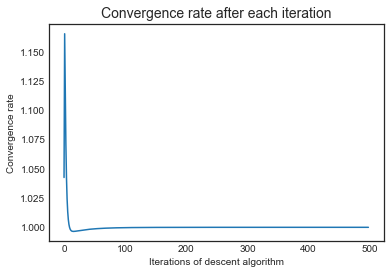

In [343]:
convergence_rate_plot(W_history)

#### We see that for classic GD, the convergence rate converges towards 1, therefore we can say conclude that our GD iterates $w_k$ converge.

## Q16 Apply random batch SGD for this regression problem:
$$
w_{n+1} = w_n - \eta \nabla E_{I_{n+1}}(w_n) \, ,
$$
where $(I_n)_n$ is a sequence of iid random variables uniform on $\{1,\ldots,N\}$.

First we write the batch SGD algorithm:

In [304]:
def batch_SGD(X_train, y_train, w0, alpha, iterations, batch_size, seed):
    """
    This function does batch SGD for the same error function as defined before.
    
    It returns
    W_history : a list of values taken by w throughout the iterations
    w : the last value taken by w
    """
    np.random.seed(seed)      # So that we can reproduce results  
    N = X_train.shape[0]                  # number of training examples
    W_history = []
    w = w0
    
    for i in range(iterations):
        # Step 1: Shuffle (X, Y)
        permutation = list(np.random.permutation(N))
        shuffled_X = X_train[permutation, :]
        shuffled_y = [y_train[idx] for idx in permutation]
        shuffled_y = np.array(shuffled_y)
        
        # Step 2: Take the first b = batch_size training examples
        X_batch = shuffled_X[:batch_size, :]
        y_batch = shuffled_y[:batch_size]
        
        # Step 3: Do the actual gradient update
        y_pred = X_batch @ w
        grad = (y_pred - y_batch) @ X_batch / N
        w = w - alpha*grad
        
        W_history.append(w)
        
    return W_history, w

In [305]:
X_train, y_train = create_data(1000)
w0 = np.array([-0.5, 2.0])

In [306]:
W_history, w = batch_SGD(X_train, y_train, w0, alpha = 0.1, iterations = 10000, batch_size = 30, seed = 10)
w

array([1.97453875, 5.00258464])

**Comment** : We see that batch SGD gives us results that are very close to our true values $[2, 5]$. That does not yet mean that the iterates of the algorithm converge, because they can potentially oscillate around a certain value, but still give a good approximation.

## Q17. Show that the SGD iterates do not converge.

First we write the SGD algorithm, the previous was batch SGD.

In [344]:
def SGD(X_train, y_train, w0, alpha, epochs, seed):
    """
    This function does SGD for the same error function as defined before.
    
    It returns
    W_history : a list of values taken by w throughout the iterations
    w : the last value taken by w
    """
    np.random.seed(seed)      # So that we can reproduce results  
    N = X_train.shape[0]                  # number of training examples
    W_history = []
    w = w0
    
    for i in range(epochs):   #We iterate over the number of epochs we fix
        
        for k in range(N): #We iterate over the entire training set
 
            y_pred = X_train[k,:] @ w
            grad = (y_pred - y_train[k]) * X_train[k,:] / N
            w = w - alpha*grad
            W_history.append(w)
        
    return W_history, w

In [345]:
X_train, y_train = create_data(100)
w0 = np.array([-0.5, 2.0])

In [346]:
W_history, w = SGD(X_train, y_train, w0, alpha = 0.1, epochs = 100, seed = 10)
w

array([1.95000803, 5.07029877])

The last value for w is [1.95000803 5.07029877] and the last value for the convergence rate: 1.00036226148772


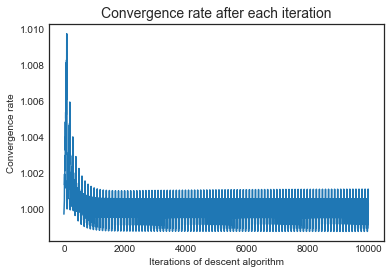

In [347]:
convergence_rate_plot(W_history)

**Conclusion: We see clearly on this plot that our iterates $w_k$ from SGD do not converge. If they did converge, we should observe the convergence rate to come closer to 1 over the number of iterations.**